In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import copy

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

from torch import (
    allclose,
    cat,
    cuda,
    device,
    int32,
    linspace,
    manual_seed,
    rand,
    rand_like,
)
from torch.nn import (
    Conv2d,
    CrossEntropyLoss,
    Flatten,
    Identity,
    Linear,
    Module,
    MSELoss,
    ReLU,
    Sequential,
)

from torch.nn.functional import cross_entropy, relu
from torchvision.models import resnet18, resnet50

from backpack import backpack, extend
from backpack.custom_module.graph_utils import BackpackTracer

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

manual_seed(0)

from tqdm import tqdm


### 2. Load data
<a id='section_2'></a>

In [19]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, filename_csv, transform = None):
        # read the csv file
        self.df = pd.read_csv(filename_csv, sep=',')
        # self.df = self.df.dropna(axis=0)
        # save cols
        self.input_cols = self.df['image'].tolist()
        self.output_cols = self.df['class'].tolist()
        self.transform = transform
        

    def __len__(self):
        # here i will return the number of samples in the dataset
        return len(self.df)

    def __getitem__(self, idx):
        # here i will load the file in position idx
        image_name = self.input_cols[idx]
        # split in input / ground-truth
        
        image = np.array(Image.open("T:/CUB_dataset/images/" + image_name))

        augmented_images = self.transform(image=image)
        image = augmented_images['image']

        # return values
        return image, self.output_cols[idx]

In [20]:
transform_train = A.Compose([
  A.Resize(64,64),
  A.HorizontalFlip(),
  A.Normalize(
    mean=[0.485, 0.456, 0.406],               
    std=[0.229, 0.224, 0.225]),
  ToTensorV2()
])

transform_test = A.Compose([
  A.Resize(64,64),
  A.Normalize(
    mean=[0.485, 0.456, 0.406],               
    std=[0.229, 0.224, 0.225]),
  ToTensorV2()
])

In [29]:
#Create the training dataset

train_ds = Dataset('T:/CUB_dataset/train.csv', transform_train)
image, c = train_ds.__getitem__(8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4831371].


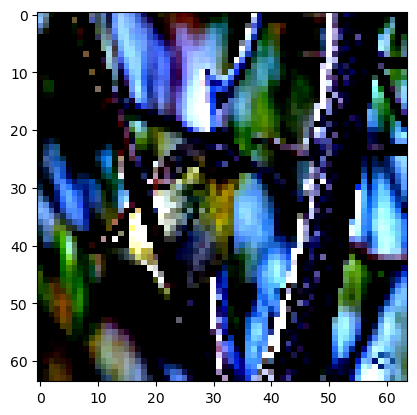

In [30]:
#Showing an example

plt.imshow(image.permute(1, 2, 0))
plt.show()

In [31]:
# Create the validation dataset

val_ds = Dataset('T:/CUB_dataset/val.csv', transform_train)

### 3. Load Model
<a id='section_3'></a>

Test w/ Backpack to verify correctness of the converter + extension

In [33]:
DEVICE = "cuda"

loss_function = extend(MSELoss().to(DEVICE))
model = resnet50(num_classes=200).to(DEVICE).eval()

model = extend(model, use_converter=True)

def print_table(module: Module) -> None:
    """Prints a table of the module.

    Args:
        module: module to analyze
    """
    graph = BackpackTracer().trace(module)
    graph.print_tabular()


print_table(model)

opcode       name                   target                 args                                   kwargs
-----------  ---------------------  ---------------------  -------------------------------------  --------
placeholder  x                      x                      ()                                     {}
call_module  conv1                  conv1                  (x,)                                   {}
call_module  bn1                    bn1                    (conv1,)                               {}
call_module  relu                   relu                   (bn1,)                                 {}
call_module  maxpool                maxpool                (relu,)                                {}
call_module  layer1_0_conv1         layer1.0.conv1         (maxpool,)                             {}
call_module  layer1_0_bn1           layer1.0.bn1           (layer1_0_conv1,)                      {}
call_module  layer1_0_relu0         layer1.0.relu0         (layer1_0_bn1,)       

In [35]:
model = resnet50(num_classes=200).to(DEVICE).train()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training (hoping)

In [24]:
def prepare_dataset(inp_file, batch_size=100, seq_length=50):
    # Load the data from file
    arr = np.load(inp_file)

    # Determine how many full batches we can make
    num_batches = (arr.size - 1) // (batch_size * seq_length)
    if num_batches == 0:
        raise ValueError(
            "This dataset is too small to use with "
            f"batch_size={batch_size} and seq_length={seq_length}."
        )

    # Truncate array to fit exactly into num_batches
    x = arr[:num_batches * batch_size * seq_length]
    y = arr[1:num_batches * batch_size * seq_length + 1]

    # Reshape so each row is one sequence
    X = x.reshape(-1, seq_length)
    Y = y.reshape(-1, seq_length)

    # Create a TensorDataset and wrap it in a DataLoader
    dataset = TensorDataset(
        torch.Tensor(X).long(),
        torch.Tensor(Y).long()
    )
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    return dataloader


In [35]:
train_filepath = "C:/Users/user/Desktop/PhD/Paper - Manini/FisherUnlearning/data/train.npy"
test_filepath = "C:/Users/user/Desktop/PhD/Paper - Manini/FisherUnlearning/data/test.npy"

batch_size = 100
seq_length = 50

train_dataloader = prepare_dataset(train_filepath, batch_size, seq_length)
test_dataloader = prepare_dataset(test_filepath, batch_size, seq_length)

for i, (X_batch, Y_batch) in enumerate(train_dataloader):
    print("Batch index:", i)
    print("X_batch shape:", X_batch.shape)
    print("Y_batch shape:", Y_batch.shape)
    break  # Stop after the first batch

#TrainLoader has 512 Batches
#TestLoader has 128 Batches

Batch index: 0
X_batch shape: torch.Size([100, 50])
Y_batch shape: torch.Size([100, 50])


In [36]:
loss_function = nn.CrossEntropyLoss()
#optimizer = optim.SGD(tolstoi_char_rnn_custom.parameters(), lr=0.04)
optimizer = optim.Adam(tolstoi_char_rnn_custom.parameters(), lr=0.001)


# Create a scheduler, e.g., ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.0001,    # how much to reduce the LR by
    patience=4,    # how many epochs to wait before reducing LR
    verbose=True   # prints a message each time LR is reduced
)

n_epochs = 1000
best_model = None
best_loss = np.inf
patience = 8

for epoch in tqdm(range(n_epochs)):
    ###################
    # Training phase
    ###################
    tolstoi_char_rnn_custom.train()
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        y_pred = tolstoi_char_rnn_custom(X_batch.to(DEVICE))
        loss = loss_function(y_pred, y_batch.to(DEVICE))
        loss.backward()
        optimizer.step()
    
    ###################
    # Validation phase
    ###################
    tolstoi_char_rnn_custom.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            y_pred = tolstoi_char_rnn_custom(X_batch.to(DEVICE))
            val_loss += loss_function(y_pred, y_batch.to(DEVICE))
   
    # Step the scheduler using the validation loss
    scheduler.step(val_loss)

    # Check for best model & early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = tolstoi_char_rnn_custom.state_dict()
        torch.save(best_model, "single-char.pth")
        patience = 20
        print("**BEST**", end="")
    else:
        patience -= 1

    print(f"Epoch {epoch}: Cross-entropy: {val_loss:.4f}")

    if patience <= 0:
        break


  0%|          | 1/1000 [00:17<4:53:57, 17.66s/it]

**BEST**Epoch 0: Cross-entropy: 339.9692


  0%|          | 2/1000 [00:35<4:51:06, 17.50s/it]

**BEST**Epoch 1: Cross-entropy: 339.6379


  0%|          | 3/1000 [00:52<4:48:20, 17.35s/it]

**BEST**Epoch 2: Cross-entropy: 339.6246


  0%|          | 4/1000 [01:09<4:46:39, 17.27s/it]

**BEST**Epoch 3: Cross-entropy: 339.5884


  0%|          | 5/1000 [01:26<4:46:10, 17.26s/it]

**BEST**Epoch 4: Cross-entropy: 339.4312


  1%|          | 6/1000 [01:43<4:46:02, 17.27s/it]

Epoch 5: Cross-entropy: 339.6255


  1%|          | 7/1000 [02:01<4:45:09, 17.23s/it]

Epoch 6: Cross-entropy: 339.4424


  1%|          | 8/1000 [02:18<4:44:18, 17.20s/it]

Epoch 7: Cross-entropy: 339.5302


  1%|          | 9/1000 [02:35<4:43:42, 17.18s/it]

Epoch 8: Cross-entropy: 339.4560


  1%|          | 10/1000 [02:52<4:43:09, 17.16s/it]

Epoch 9: Cross-entropy: 339.4649


  1%|          | 11/1000 [03:09<4:42:54, 17.16s/it]

Epoch 10: Cross-entropy: 339.4488


  1%|          | 12/1000 [03:26<4:42:24, 17.15s/it]

Epoch 11: Cross-entropy: 339.4341


  1%|▏         | 13/1000 [03:43<4:42:27, 17.17s/it]

**BEST**Epoch 12: Cross-entropy: 339.4211


  1%|▏         | 14/1000 [04:01<4:42:19, 17.18s/it]

**BEST**Epoch 13: Cross-entropy: 339.4084


  2%|▏         | 15/1000 [04:18<4:42:12, 17.19s/it]

**BEST**Epoch 14: Cross-entropy: 339.3970


  2%|▏         | 16/1000 [04:35<4:41:58, 17.19s/it]

**BEST**Epoch 15: Cross-entropy: 339.3863


  2%|▏         | 17/1000 [04:52<4:41:56, 17.21s/it]

**BEST**Epoch 16: Cross-entropy: 339.3762


  2%|▏         | 18/1000 [05:10<4:41:44, 17.21s/it]

**BEST**Epoch 17: Cross-entropy: 339.3664


  2%|▏         | 19/1000 [05:27<4:41:25, 17.21s/it]

**BEST**Epoch 18: Cross-entropy: 339.3574


  2%|▏         | 20/1000 [05:44<4:41:08, 17.21s/it]

**BEST**Epoch 19: Cross-entropy: 339.3488


  2%|▏         | 21/1000 [06:01<4:40:50, 17.21s/it]

**BEST**Epoch 20: Cross-entropy: 339.3403


  2%|▏         | 22/1000 [06:18<4:40:37, 17.22s/it]

**BEST**Epoch 21: Cross-entropy: 339.3325


  2%|▏         | 23/1000 [06:36<4:40:29, 17.23s/it]

**BEST**Epoch 22: Cross-entropy: 339.3251


  2%|▏         | 24/1000 [06:53<4:40:14, 17.23s/it]

**BEST**Epoch 23: Cross-entropy: 339.3180


  2%|▎         | 25/1000 [07:10<4:39:59, 17.23s/it]

**BEST**Epoch 24: Cross-entropy: 339.3111


  3%|▎         | 26/1000 [07:27<4:39:47, 17.24s/it]

**BEST**Epoch 25: Cross-entropy: 339.3047


  3%|▎         | 27/1000 [07:45<4:39:33, 17.24s/it]

**BEST**Epoch 26: Cross-entropy: 339.2988


  3%|▎         | 28/1000 [08:02<4:39:08, 17.23s/it]

**BEST**Epoch 27: Cross-entropy: 339.2931


  3%|▎         | 29/1000 [08:19<4:38:54, 17.23s/it]

**BEST**Epoch 28: Cross-entropy: 339.2883


  3%|▎         | 30/1000 [08:36<4:38:42, 17.24s/it]

**BEST**Epoch 29: Cross-entropy: 339.2882


  3%|▎         | 31/1000 [08:54<4:38:18, 17.23s/it]

Epoch 30: Cross-entropy: 339.2883


  3%|▎         | 32/1000 [09:11<4:37:52, 17.22s/it]

Epoch 31: Cross-entropy: 339.2883


  3%|▎         | 33/1000 [09:28<4:37:37, 17.23s/it]

Epoch 32: Cross-entropy: 339.2883


  3%|▎         | 34/1000 [09:45<4:37:17, 17.22s/it]

Epoch 33: Cross-entropy: 339.2882


  4%|▎         | 35/1000 [10:02<4:37:04, 17.23s/it]

Epoch 34: Cross-entropy: 339.2882


  4%|▎         | 36/1000 [10:20<4:37:30, 17.27s/it]

Epoch 35: Cross-entropy: 339.2883


  4%|▎         | 37/1000 [10:37<4:37:23, 17.28s/it]

Epoch 36: Cross-entropy: 339.2882


  4%|▍         | 38/1000 [10:55<4:36:27, 17.24s/it]

Epoch 37: Cross-entropy: 339.2882


KeyboardInterrupt: 

In [31]:
# 0) Reverse vocab
idx2char = {idx: char for char, idx in vocab.items()}

# 1) Evaluation loop
tolstoi_char_rnn_custom.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        # 2) Get the model output and predicted indices
        y_pred = tolstoi_char_rnn_custom(X_batch)
        print(y_pred.shape)
        pred_indices = torch.argmax(y_pred,dim=1)  # (batch_size, seq_length)
        print(pred_indices.shape)
        # 3) Convert predicted IDs and true IDs to strings
        for i in range(len(X_batch)):
            pred_string = ''.join(idx2char[idx.item()] for idx in pred_indices[i])
            true_string = ''.join(idx2char[idx.item()] for idx in y_batch[i])
            
            print("Predicted:", pred_string)
            print("True:     ", true_string)
            print("----------")

        # Optionally break early to just inspect one batch
        break


torch.Size([100, 28, 100])
torch.Size([100, 100])
Predicted: e th n     ete  e  an n    a        hon     hn     aan  aen tan  aa   aeeeehhe  he te  aa   tnto neh
True:      e princess. he had changed verymuch since princess mary had last seen him. then he had been a briskc
----------
Predicted: h       t           a   aondho  he th     tnahn nn  to                ta    th   n  th hh e     t n 
True:      heerful selfassured old man now he seemed a pitiful bewilderedperson. while talking to princess mary
----------
Predicted:  he te   ng     a            hn n tn tn  t        t e     he t n aa    ahe ten  eahen   tn    ah    
True:       he continually looked round asif asking everyone whether he was doing the right thing. after thedes
----------
Predicted:       n  t  to     and a  ten hh       ahee   t   h  aen an    h e           t      ah hen  t    hhe
True:      truction of moscow and of his property thrown out of his accustomedgroove he seemed to have lost the
----------
Predicted:

In [ ]:
saved_model = FLNet2()
saved_model.load_state_dict(torch.load(load_path, weights_only=True))

In [ ]:
def create_dataloader(idx_client, _list_trainloader, percentage_to_remove):
    list_trainloader = copy.deepcopy(_list_trainloader)
    client_dataset = list_trainloader[idx_client].dataset

    num_samples_to_remove = int(len(client_dataset) * percentage_to_remove)
    num_samples_to_keep = len(client_dataset) - num_samples_to_remove
    
    if num_samples_to_keep != 0:
        new_dataset = TensorDataset(client_dataset[:num_samples_to_keep][0], client_dataset[:num_samples_to_keep][1])
        list_trainloader[idx_client] = DataLoader(new_dataset, batch_size=128)

    else:
        list_trainloader.pop(idx_client)

    return list_trainloader, num_samples_to_remove

In [ ]:
from torch.utils.data import ConcatDataset

def analyze_removal(_model, _trainloader_list):
    remove_percentages = np.linspace(0, 1, 10)
    trainloader_list = copy.deepcopy(_trainloader_list)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = copy.deepcopy(_model).to(device)
    criterion = nn.CrossEntropyLoss()


    # Shuffle training datasets for each client only at the beginning
    # (this is done to avoid fictitious determinism in the results)
    training_datasets = [loader.dataset for loader in trainloader_list]
    shuffled_training_datasets = []
    for dataset in training_datasets:
        indices = np.random.permutation(len(dataset))
        shuffled_training_datasets.append(TensorDataset(dataset[indices][0], dataset[indices][1]))
    shuffled_trainloader_list = [DataLoader(dataset, batch_size=128) for dataset in shuffled_training_datasets]

    results = []

    for remove_percentage in remove_percentages:

        trainloader_list, _ = create_dataloader(party_to_be_erased, shuffled_trainloader_list, remove_percentage)
        
        client_dataset = ConcatDataset([loader.dataset for loader in trainloader_list])
        loader = DataLoader(client_dataset, batch_size=128)

        loss_sum = 0
        grad_sum = torch.zeros_like(torch.cat([param.flatten() for param in model.parameters()]))
        number_of_batches = 0

        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Sum quantities
            loss_sum += loss.cpu().item()
            grad_sum += torch.cat([param.grad.flatten() for param in model.parameters()])
            number_of_batches += 1
            
        grad_norm = torch.norm(grad_sum).cpu().item() / number_of_batches
        loss = loss_sum / number_of_batches

        
        # Store results
        results.append({
            'removal_percentage': remove_percentage,
            'gradient_norm': grad_norm,
            'loss': loss
        })
        
        print(f"Removal percentage: {remove_percentage:.2f}")
        print(f"  - Number of samples: {sum([len(loader.dataset) for loader in trainloader_list])}")
        print(f"  - Gradient norm: {grad_norm:.4f}")
        print(f"  - Loss: {loss:.4f}")
        print("-" * 50)

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Create plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot gradient norm vs Removal percentage
    axs[0].plot(results_df['removal_percentage'], results_df['gradient_norm'], 'o-')
    axs[0].set_title('Gradient Norm vs. Removal Percentage')
    axs[0].set_xlabel('Removal Percentage')
    axs[0].set_ylabel('Gradient Norm')
    axs[0].grid(True)

    # Plot loss vs Removal percentage
    axs[1].plot(results_df['removal_percentage'], results_df['loss'], 'o-')
    axs[1].set_title('Loss vs. Removal Percentage')
    axs[1].set_xlabel('Removal Percentage')
    axs[1].set_ylabel('Loss')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

#analyze_removal(saved_model, trainloader_lst)

In [ ]:
from backpack import backpack, extend
from backpack.extensions import DiagHessian

trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 

#Use the model if coming from the training or load if you have it downloaded
final_model = copy.deepcopy(saved_model)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

delta = 0.0001

# Create weights list
weights_unlearned = [1] * len(trainloader_list)
weights_unlearned[party_to_be_erased] = 1 - delta

weights_unlearned=torch.tensor(weights_unlearned, dtype=torch.float32)

weights_half = weights_unlearned
weights_half[party_to_be_erased] = 1 - delta / 2


Compute Hessians

In [ ]:
def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h') and param.requires_grad:
            diag_hessian_params[name] = param.diag_h.clone().detach()
            # Cleanup to avoid leftover references
            del param.diag_h

    return diag_hessian_params


class AccumulatedDiagHessian:

    def __init__(self, model, criterion, device=None):
        self.model = model
        self.criterion = criterion
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')

        # Will store final per-client Hessians after summing across that client's batches
        self.client_hessians = []
        self.total_batches = 0
        self._computed = False

    def compute_client_hessians(self, dataloader_list):
  
        self.model = self.model.to(self.device)
        self.client_hessians = []
        self.total_batches = 0

        for loader_idx, loader in enumerate(dataloader_list):
            accumulated_diag_h = {}
            print(f"[Hessian] Calculating diagonal Hessian for client {loader_idx}...")
            
            for batch_idx, (inputs, targets) in enumerate(loader):
                # Compute the diag Hessian for this batch
                diag_h = compute_diag_hessian(self.model, self.criterion, inputs, targets, device=self.device)

                # Accumulate
                for name, value in diag_h.items():
                    if name not in accumulated_diag_h:
                        accumulated_diag_h[name] = value
                    else:
                        accumulated_diag_h[name] += value

                self.total_batches += 1

            # Store the accumulated Hessian for this client
            self.client_hessians.append(accumulated_diag_h)

        self._computed = True

    def weighted_hessian(self, weights=None):

        if not self._computed:
            raise RuntimeError("You must call `compute_client_hessians(...)` before requesting weights.")

        n_clients = len(self.client_hessians)
        if weights is None:
            weights = [1.0] * n_clients
        if len(weights) != n_clients:
            raise ValueError("Length of weights must match number of clients.")

        weighted_hessian = {}

        for name in self.client_hessians[0].keys():
            weighted_hessian[name] = sum(
                self.client_hessians[i][name] * weights[i] for i in range(len(self.client_hessians))
            ) / self.total_batches
        
        return weighted_hessian

In [ ]:
if COMPUTE_HESSIAN:
    hessian_calculator = AccumulatedDiagHessian(final_model, criterion)
    hessian_calculator.compute_client_hessians(trainloader_list)
    accumulated_diag_h = hessian_calculator.weighted_hessian()
    accumulated_diag_h_removed = hessian_calculator.weighted_hessian(weights_unlearned)

OUR METHOD

In [ ]:
def compute_true_info(hessian, hessian_delta, delta):
    A_list = [torch.empty_like(p) for p in hessian.values()]
    B_list = [torch.empty_like(p) for p in hessian.values()]
    for i,k in enumerate(hessian.keys()): 
        print(k)

        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_delta[k]==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        ratio = hessian_delta[k]/hessian[k]
        A=1/2 * torch.log(ratio)/delta
        B=1/2 * (1-ratio)/delta

        A[degeneracies_indices]=0
        B[degeneracies_indices]=0

        assert torch.sum(torch.isnan(A))==0, f"NaN values in A: {torch.sum(torch.isnan(A))}"
        assert torch.sum(torch.isnan(B))==0, f"NaN values in B: {torch.sum(torch.isnan(B))}"
        assert torch.sum(torch.isinf(A))==0, f"Inf values in A: {torch.sum(torch.isinf(A))}"
        assert torch.sum(torch.isinf(B))==0, f"Inf values in B: {torch.sum(torch.isinf(B))}"

        A_list[i]=A
        B_list[i]=B

    C = sum([torch.sum(A_list[i]+B_list[i]).item() for i in range(len(A_list))])

    information_true=[(A_list[i]+B_list[i])*C + 2*torch.pow(B_list[i],2) for i in range(len(hessian.keys()))]

    return information_true

In [ ]:
def compute_second_deriv_info(hessian, hessian_half_delta, hessian_delta, delta):
    information = []
    for k in hessian.keys(): 
        print(k)
        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_delta[k]==0)
        degeneracies_indices = torch.logical_or(degeneracies_indices, torch.pow(hessian_half_delta[k],2)==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        A=1/2 * torch.log(hessian_delta[k]*hessian[k]/torch.pow(hessian_half_delta[k],2))
        #plt.plot(A.cpu().flatten(), label=k+'A')
        B=1/2 * (2*hessian_half_delta[k]/hessian[k]-hessian_delta[k]/hessian[k] -1)
        print(np.var(B.cpu().flatten().numpy()))
        print(np.mean(B.cpu().flatten().numpy()))
        #plt.plot(B.cpu().flatten(), label=k+'B')

        #plt.legend()
        #plt.show()

        I=-(A+B)/((delta/2)**2)

        I[degeneracies_indices]=0

        assert torch.sum(torch.isnan(I))==0, f"NaN values in {k}: {torch.sum(torch.isnan(I))}"
        assert torch.sum(torch.isinf(I))==0, f"Inf values in {k}: {torch.sum(torch.isinf(I))}"

        information.append(I)

    return information

In [ ]:
def delta_hessian(hessian, hessian_delta, delta):
    delta_hessian = []
    for k in hessian.keys():
        delta_hessian.append(torch.abs(hessian_delta[k] - hessian[k]) / delta)
    return delta_hessian

In [ ]:
if COMPUTE_HESSIAN:  
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    info_true = compute_true_info(accumulated_diag_h, accumulated_diag_h_removed, torch.as_tensor([delta]).to(device))
    #info_true = compute_second_deriv_info(accumulated_diag_h, accumulated_diag_h_half, accumulated_diag_h_removed, torch.as_tensor([delta]).to(device))
    #info_true = delta_hessian(accumulated_diag_h, accumulated_diag_h_removed, torch.as_tensor([delta]).to(device))
    

In [ ]:
if COMPUTE_HESSIAN:
    import pickle

    with open('cached/info_true.pkl', 'wb') as f:
        pickle.dump(info_true, f)

Load hessians

In [ ]:
import pickle
with open('cached/info_true.pkl', 'rb') as f:
    info_true = pickle.load(f)

In [ ]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [0, 98])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=30, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

In [ ]:
plot_information(info_true)

Helper Functions

In [ ]:
import torchmetrics
import seaborn as sns

# create validation routine
def validate(net, dl, n_classes, device):
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=n_classes)
    # move metric to device
    net.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    net.eval()
    # at the end of epoch, validate model
    for loader_idx, loader in enumerate(dl):
        for inputs, targets in loader:
        
            inputs = inputs.to(device)
            targets = targets.to(device)
            # remove singleton dimension
            targets = targets.squeeze()
            # get output
            with torch.no_grad():
                # perform prediction
                logits = net(inputs)
            # update metrics
            _, predicted = torch.max(logits.data, 1)
            tm_acc.update(predicted, targets)
            tm_con.update(predicted, targets)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    
    return acc, con


def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)


# Compute accuracy for each client
def compute_accuracy(model, testloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

def compute_accuracy_per_client(model, testloader_list):
    for i, testloader in enumerate(testloader_list):
        acc = compute_accuracy(model, testloader)
        print(f"Accuracy for class {i}: {acc:.2f}%")


Compute information

In [ ]:
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))[::-1]

s_infolayers = [np.sort(p.cpu().flatten())[::-1] for p in info_true]

plt.plot(s_infocat)
plt.title('Sorted Information Values for All Parameters')
plt.show()

# from kneed import KneeLocator
# start = [0, 0, 0, 0, 0, 0, 0, 0]
# end = [-1, -1, -10000, -30, -1, -1, -1, -1]
# step = [1, 1, 1, 1, 100, 1, 1, 1]
# auto_thresholds = []
# for i in range(len(s_infolayers)):
#     kneedle = KneeLocator(range(len(s_infolayers[i][start[i]:end[i]:step[i]])), s_infolayers[i][start[i]:end[i]:step[i]], curve='convex', direction='decreasing', online=True)
#     auto_thresholds.append(start[i]+kneedle.knee*step[i])
#     print(f'Layer {i} knee:', auto_thresholds[i])

auto_percentage = 12
custom_percentages = [None, None, None, None, None, None, None, None]

percentages = [auto_percentage if custom_percentages[i] is None else custom_percentages[i] for i in range(len(custom_percentages))]

auto_thresholds = [len(s_infolayers[i]) // 100 * percentages[i] for i in range(len(s_infolayers))]

custom_thresholds = [None, None, None, None, None, None, None, None]

thresholds = [auto_thresholds[i] if custom_thresholds[i] is None else custom_thresholds[i] for i in range(len(custom_thresholds))]

for i in range(len(s_infolayers)):
    fig, axs = plt.subplots(1, 1, figsize=(14, 5))
    axs.plot(s_infolayers[i])
    axs.axvline(auto_thresholds[i], color='red', linestyle='--', label='Auto threshold')
    axs.axvline(thresholds[i], color='green', linestyle='--', label='Custom threshold')
    axs.legend()
    axs.set_title(f'Thresholds for layer {i}')
    fig.show()

    


Parameters reset unlearning

In [ ]:
thresholds_values = [p[thresholds[i]] for i,p in enumerate(s_infolayers)]
retrain_param_indices = []
for i, p in enumerate(info_true):
    if custom_thresholds[i] != 0:
        indices = torch.argwhere(p > thresholds_values[i])
        retrain_param_indices.append(indices)
    else:
        retrain_param_indices.append(torch.empty(size=[0 for _ in range(p.dim())]))

model_reset = copy.deepcopy(saved_model).cpu()
model_null = FLNet2()

original_parameters = model_reset.state_dict()
null_parameters = model_null.state_dict()

reset_parameters = {}
for i, (name, p) in enumerate(model_reset.named_parameters()):
    new_p = original_parameters[name].clone()
    null_p = null_parameters[name].clone()
    #new_p[tuple(retrain_param_indices[i].t())] = null_p[tuple(retrain_param_indices[i].t())]
    new_p[tuple(retrain_param_indices[i].t())] = 0
    reset_parameters[name] = new_p

model_reset.load_state_dict(reset_parameters)

print("Accuracy before resetting:")
compute_accuracy_per_client(saved_model, trainloader_class_list)
print("Accuracy after resetting:")
compute_accuracy_per_client(model_reset, trainloader_class_list)



In [ ]:
print("Confusion matrix before resetting:")
acc, conf_mat = validate(saved_model, trainloader_class_list, 10, device)
plot_confusion_matrix(conf_mat)
print("Confusion matrix after resetting:")
acc, conf_mat = validate(model_reset, trainloader_class_list, 10, device)
plot_confusion_matrix(conf_mat)

In [ ]:
def print_info_stats(information):
    """
    Compute statistics for the information values.
    """
    # Flatten the information values and convert to numpy
    layers_total_information = [torch.sum(p) for p in information]

    for i, info in enumerate(layers_total_information):
        print(f"Layer {i} - Total Information: {info:.4f}")
    
    print(f"Total Information: {sum(layers_total_information):.4f}")

print("Information before resetting:")
print_info_stats(info_true)

reset_info_true = copy.deepcopy(info_true)
for i in range(len(reset_info_true)):
    reset_info_true[i][tuple(retrain_param_indices[i].t())] = 0
print("Information after resetting:")
print_info_stats(reset_info_true)

In [ ]:
class UnlearnNet(nn.Module):
    """
    A module that wraps an existing model and selectively retrains individual 
    scalar elements (indices) of its parameters while keeping the rest fixed.
    """

    def __init__(self, base_model, indices_to_retrain):
        """
        Args:
            base_model (nn.Module): The original model whose parameters 
                                    we want to partially retrain.
            indices_to_retrain (List[torch.Tensor]): For each parameter of 
                                    'base_model', a tensor of indices indicating 
                                    which scalar values should be retrained.
        """
        super().__init__()

        # We store the base model inside a dictionary to allow
        # functional calls later without overshadowing state_dict keys.
        self.inner_model = {"model": base_model}

        # Move any index tensors to CPU and store them.
        self.indices_to_retrain = [idx.cpu() for idx in indices_to_retrain]

        # Create a copy of the base model's parameters as buffers, where
        # we zero out the positions that will be retrained.
        base_params = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            # Detach a clone of the original parameter
            cloned_param = param.clone().detach()
            # Zero-out the entries we plan to retrain
            if len(self.indices_to_retrain[i]) > 0:
                cloned_param[tuple(self.indices_to_retrain[i].t())] = 0
            base_params[param_name] = cloned_param

        # Register these base parameters as buffers so they are not optimized
        for param_name, buf in base_params.items():
            buf_name = param_name.replace(".", "_")
            self.register_buffer(f"base_{buf_name}", buf)

        # Create the new learnable parameters for only the chosen indices
        retrain_params_dict = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # We create a 1D tensor (one entry per retrained element)
            key = param_name.replace(".", "_")
            retrain_params_dict[key] = nn.Parameter(
                torch.zeros(len(self.indices_to_retrain[i]))
            )
        self.retrain_params = nn.ParameterDict(retrain_params_dict)

        # Build sparse masks to apply the learnable values at the correct indices
        sparse_masks = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # 'retrain_indices' has shape (k, n_dims). Add a final dim to index positions in the retrain-param vector.
            retrain_indices = indices_to_retrain[i]
            k = retrain_indices.size(0)

            # Create an index column [0..k-1], then concatenate it with 'retrain_indices'.
            row_idx = torch.arange(k).unsqueeze(1)
            final_idx_matrix = torch.cat([retrain_indices, row_idx], dim=1)

            # A sparse_coo_tensor expects indices with shape (ndim, nnz). Transpose to (n_dims+1, k).
            indices_for_sparse = final_idx_matrix.t().contiguous()

            # Append k as the final dimension so each retrained element indexes differently.
            mask_shape = tuple(param.size()) + (k,)

            # Build the sparse mask with 1.0 at the retrained indices.
            key = f"mask_{param_name.replace('.', '_')}"
            sparse_masks[key] = torch.sparse_coo_tensor(
                indices_for_sparse,
                torch.ones(k, dtype=torch.float32),
                size=mask_shape
            )
        
        # Register these sparse masks as buffers
        for mask_name, mask in sparse_masks.items():
            self.register_buffer(mask_name, mask.coalesce())

    def contract_last_dim_with_vector(self, sp_tensor: torch.Tensor, vec: torch.Tensor) -> torch.Tensor:
        """
        Contract the last dimension of a sparse tensor (shape [..., N]) with
        a dense vector of shape (N,), returning a sparse tensor of shape [...].

        This effectively applies elementwise multiplication with 'vec'
        across the last dimension of 'sp_tensor'.
        """

        # Extract indices (shape [ndim, nnz]) and values (shape [nnz])
        indices = sp_tensor.indices()
        values = sp_tensor.values()

        # Multiply each sparse value by the corresponding element in 'vec'
        # indices[-1] indicates which element in 'vec' to use per sparse entry
        new_values = values * vec[indices[-1]]

        # Create a new sparse_coo_tensor with one fewer dimension
        new_shape = sp_tensor.shape[:-1]
        new_indices = indices[:-1, :]  # drop the last dimension index row

        result_tensor = torch.sparse_coo_tensor(
            new_indices,
            new_values,
            size=new_shape,
            dtype=sp_tensor.dtype,
            device=sp_tensor.device
        )

        return result_tensor

    def forward(self, x):
        """
        Forward pass using a functional call to the base model. We reconstruct 
        final parameters by adding the base buffers and the contracted retrain 
        parameters at the relevant indices.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )

        # Perform a functional forward pass with the reconstructed parameters
        return torch.func.functional_call(model, final_params, x)
    
    def get_retrained_params(self):
        """
        Returns the retrained parameters of the model.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )
        
        detached_params = {}
        for key, value in final_params.items():
            detached_params[key] = value.cpu().detach()
        return detached_params
    

In [ ]:
assert RETRAIN
#Test
unlearn_model = UnlearnNet(model_reset, retrain_param_indices)

print("Unlearn model parameters:")
for name , param in unlearn_model.named_parameters():
    print(name, param.shape)

# print("Accuracy (reset before retrain)")
# compute_accuracy_per_client(unlearn_model, trainloader_class_list)


In [ ]:
num_of_repeats = 1
num_fl_rounds = 1

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 2

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

party_models_dict = {}
initial_model = unlearn_model
model_dict = {}
parties = list(range(5))
del parties[party_to_be_erased]

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=len(parties), fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        model = copy.deepcopy(initial_model)
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in parties:

            if fusion_key == 'Retrain':
                break
            else:
                print(f"Training party {party_id}")
                model = UnlearnNet(model_reset, retrain_param_indices)
                model.load_state_dict(current_model_state_dict)
                model.to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt=None)
                model_update_copy = UnlearnNet(model_reset, retrain_param_indices)
                model_update_copy.load_state_dict(model_update.state_dict())
                model_update_copy.to("cpu")
                party_models.append(model_update_copy)
                party_losses.append(party_loss)

            grad_norm = 0.0
            for name,param in model_update.named_parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).cpu().item()
                    #print(f"Gradient norm for {name}: {grad_norm}")
                else:
                    #print(f"Gradient is None for {name}")
                    pass
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

        eval_model = copy.deepcopy(initial_model).to("cpu")
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

In [ ]:
print("Accuracy after retrain")
compute_accuracy_per_client(eval_model, trainloader_class_list)


In [ ]:
print("Confusion matrix after retrain:")
acc, conf_mat = validate(eval_model, trainloader_class_list, 10, "cuda")
plot_confusion_matrix(conf_mat)

In [ ]:
trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 


final_model = FLNet2()
unlearned_params = eval_model.get_retrained_params()


final_model.load_state_dict(unlearned_params)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

delta = 0.01

# Create weights list
weights_unlearned = [1] * len(trainloader_list)
weights_unlearned[party_to_be_erased] = 0
weights_delta = weights_unlearned.copy()
weights_delta[party_to_be_erased] = delta

weights_unlearned=torch.tensor(weights_unlearned, dtype=torch.float32)
weights_delta=torch.tensor(weights_delta, dtype=torch.float32)

accumulated_diag_h_retrain = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights_unlearned)
accumulated_diag_h_removed_retrain = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights_delta)


In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
info_true = compute_true_info(accumulated_diag_h_retrain, accumulated_diag_h_removed_retrain, torch.as_tensor([delta]).to(device))

plot_information(info_true)

In [ ]:
client0 = torch.load("client0")
client1 = torch.load("client1")
client2 = torch.load("client2")
client3 = torch.load("client3")
client4 = torch.load("client4")

# For NumPy arrays
import numpy as np

def count_equal_arrays(list1, list2):
    equal_count = 0
    min_length = min(len(list1), len(list2))
    
    for i in range(min_length):
        if np.array_equal(list1[i], list2[i]):
            print(list1[i])
            equal_count += 1
    
    return equal_count

count_equal_arrays(client4[6], client4[6])

import torch
import numpy as np

def tensor_list_distance(list1, list2, metric='euclidean'):
    """
    Compute various distance metrics between two lists of tensors.
    
    Args:
        list1: First list of tensors
        list2: Second list of tensors
        metric: Distance metric to use ('euclidean', 'manhattan', 'cosine', 'mean_squared', 'element_diff')
        
    Returns:
        float: The computed distance between the two tensor lists
    """
    # Make sure we only compare up to the length of the shorter list
    min_length = min(len(list1), len(list2))
    
    if min_length == 0:
        raise ValueError("At least one of the lists is empty")
        
    # Initialize distance
    distances = []
    
    # Compute distance for each pair of tensors
    for i in range(min_length):
        tensor1 = list1[i].float()  # Ensure tensors are float type
        tensor2 = list2[i].float()
        
        if metric == 'euclidean':
            # Euclidean distance
            dist = torch.sqrt(torch.sum((tensor1 - tensor2) ** 2)).item()
            distances.append(dist)
            
        elif metric == 'manhattan':
            # Manhattan (L1) distance
            dist = torch.sum(torch.abs(tensor1 - tensor2)).item()
            distances.append(dist)
            
        elif metric == 'cosine':
            # Cosine distance (1 - cosine similarity)
            dot_product = torch.sum(tensor1 * tensor2)
            norm1 = torch.sqrt(torch.sum(tensor1 ** 2))
            norm2 = torch.sqrt(torch.sum(tensor2 ** 2))
            
            # Avoid division by zero
            if norm1 == 0 or norm2 == 0:
                dist = 1.0  # Maximum distance
            else:
                cosine_sim = dot_product / (norm1 * norm2)
                # Clip to handle floating point errors
                cosine_sim = torch.clamp(cosine_sim, -1.0, 1.0)
                dist = 1.0 - cosine_sim.item()
                
            distances.append(dist)
            
        elif metric == 'mean_squared':
            # Mean squared error
            dist = torch.mean((tensor1 - tensor2) ** 2).item()
            distances.append(dist)
            
        elif metric == 'element_diff':
            # Count of different elements
            diff_count = torch.sum(tensor1 != tensor2).item()
            distances.append(diff_count)
            
        else:
            raise ValueError(f"Unknown distance metric: {metric}")
    
    # Compute average distance across all tensor pairs
    avg_distance = np.mean(distances)
    
    # Calculate additional statistics
    stats = {
        "mean": avg_distance,
        "median": np.median(distances),
        "min": np.min(distances),
        "max": np.max(distances),
        "std": np.std(distances),
        "distances": distances  # List of all pairwise distances
    }
    
    return stats

    
# Compute distances using different metrics
for metric in ['euclidean', 'element_diff']:
    result = tensor_list_distance(client0[4], client1[4], metric=metric)
    print(f"\n{metric.upper()} Distance:")
    print(f"Mean: {result['mean']:.6f}")
    print(f"Median: {result['median']:.6f}")
    print(f"Min: {result['min']:.6f}")
    print(f"Max: {result['max']:.6f}")
    print(f"Std: {result['std']:.6f}")
